In [1]:
import pandas as pd

In [2]:
prom_file_path = "surf_labeled.parquet"

In [3]:
prom_df = pd.read_parquet(prom_file_path)

In [4]:
columns_to_drop = ['node_filesystem_device_error-sum', 'node_netstat_Icmp_InErrors', 'node_netstat_Tcp_InErrs', 'node_netstat_Udp_InErrors']

prom_df = prom_df.drop(columns=columns_to_drop)


In [5]:
prom_df.drop('node_netstat_Icmp_InErrors')

KeyError: "['node_netstat_Icmp_InErrors'] not found in axis"

In [4]:
prom_df[prom_df['isAnomaly'] == True].describe()


,timestamp,node_load15,node_load1,node_load5,node_memory_Active_bytes,nvidia_gpu_power_usage_milliwatts-max,isAnomaly
count,3.814028e+06,3.814028e+06,3.814028e+06,3.814028e+06,3.814028e+06,3814028.0,3814028.0
mean,1.582939e+09,1.579717e+02,1.598725e+02,1.594948e+02,1.476477e+10,0.0,1.0
std,2.409879e+06,2.266575e+02,2.735102e+02,2.575070e+02,3.198178e+10,0.0,0.0
min,1.577874e+09,2.340000e+00,1.000000e-02,1.000000e-02,9.133670e+07,0.0,1.0
25%,1.581439e+09,6.044000e+01,6.008000e+01,6.052000e+01,4.030895e+09,0.0,1.0
50%,1.583429e+09,1.760000e+02,1.760000e+02,1.760200e+02,9.533579e+09,0.0,1.0
75%,1.585260e+09,2.328000e+02,2.318500e+02,2.324200e+02,1.671215e+10,0.0,1.0
max,1.585865e+09,2.418298e+04,2.788524e+04,2.759361e+04,2.013336e+12,0.0,1.0


In [5]:
pd.options.display.float_format = '{:.2f}'.format
prom_df['has_GPU'] = prom_df['nvidia_gpu_power_usage_milliwatts-max'] > 0



In [6]:
print("Statistics for nodes with GPU:")
print(prom_df[prom_df['has_GPU']].describe())

print("\nStatistics for nodes without GPU:")
print(prom_df[~prom_df['has_GPU']].describe())


Statistics for nodes with GPU:
       timestamp  node_load15  node_load1  node_load5  \
count       0.00         0.00        0.00        0.00   
mean         NaN          NaN         NaN         NaN   
std          NaN          NaN         NaN         NaN   
min          NaN          NaN         NaN         NaN   
25%          NaN          NaN         NaN         NaN   
50%          NaN          NaN         NaN         NaN   
75%          NaN          NaN         NaN         NaN   
max          NaN          NaN         NaN         NaN   

       node_memory_Active_bytes  nvidia_gpu_power_usage_milliwatts-max  \
count                      0.00                                   0.00   
mean                        NaN                                    NaN   
std                         NaN                                    NaN   
min                         NaN                                    NaN   
25%                         NaN                                    NaN   
50%        

In [8]:
def report_max_min(df):
    for column in df.columns.drop(['node', 'timestamp', 'has_GPU']):
        max_node = df[df[column] == df[column].max()]['node'].iloc[0]
        min_node = df[df[column] == df[column].min()]['node'].iloc[0]
        print(f"For {column}: Node {max_node} has the highest value of {df[column].max():.2f}, Node {min_node} has the lowest value of {df[column].min():.2f}.")


print("\nFor nodes without GPU:")
report_max_min(prom_df[~prom_df['has_GPU']])



For nodes without GPU:
For node_load15: Node r23n23 has the highest value of 24182.98, Node r10n1 has the lowest value of 0.01.
For node_load1: Node r23n23 has the highest value of 27885.24, Node r10n1 has the lowest value of 0.01.
For node_load5: Node r23n23 has the highest value of 27593.61, Node r10n1 has the lowest value of 0.01.
For node_memory_Active_bytes: Node r23n23 has the highest value of 2150763614208.00, Node r13n29 has the lowest value of 23953408.00.
For nvidia_gpu_power_usage_milliwatts-max: Node r10n1 has the highest value of 0.00, Node r10n1 has the lowest value of 0.00.
For isAnomaly: Node r10n1 has the highest value of 1.00, Node r10n1 has the lowest value of 0.00.


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def perform_clustering(df):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df.drop(columns=['node', 'timestamp', 'has_GPU']))

    kmeans = KMeans(n_clusters=4, random_state=0).fit(data_scaled)

    df['cluster'] = kmeans.labels_

    print(df['cluster'].value_counts())

    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=df.columns.drop(['node', 'timestamp', 'cluster', 'has_GPU']))
    for i, row in cluster_centers_df.iterrows():
        print(f"\nCluster {i} center has the following key characteristics:")
        for column in row.index:
            print(f"{column}: {row[column]:.2f}")

print("Clustering for nodes with GPU:")
perform_clustering(prom_df[prom_df['has_GPU']].copy())  

print("\nClustering for nodes without GPU:")
perform_clustering(prom_df[~prom_df['has_GPU']].copy())


Clustering for nodes with GPU:


/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    3939409
0    2690565
3     625232
2     149824
Name: cluster, dtype: int64

Cluster 0 center has the following key characteristics:
node_load15: 5.00
node_load5: 4.99
node_load1: 4.98
node_memory_Active_bytes: 23564294462.07
nvidia_gpu_power_usage_milliwatts-max: 251740.17
nvidia_gpu_temperature_celsius-max: 81.57
isAnomaly: 0.00

Cluster 1 center has the following key characteristics:
node_load15: 1.26
node_load5: 1.25
node_load1: 1.24
node_memory_Active_bytes: 6034502783.16
nvidia_gpu_power_usage_milliwatts-max: 40685.73
nvidia_gpu_temperature_celsius-max: 38.09
isAnomaly: 0.00

Cluster 2 center has the following key characteristics:
node_load15: 67.90
node_load5: 68.74
node_load1: 69.11
node_memory_Active_bytes: 38140596637.12
nvidia_gpu_power_usage_milliwatts-max: 159430.83
nvidia_gpu_temperature_celsius-max: 67.91
isAnomaly: 1.00

Cluster 3 center has the following key characteristics:
node_load15: 14.07
node_load5: 14.20
node_load1: 14.23
node_memory_Active_bytes: 7498699187

/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    96192883
3    16567971
2     3342575
1       56838
Name: cluster, dtype: int64

Cluster 0 center has the following key characteristics:
node_load15: 6.85
node_load5: 6.82
node_load1: 6.81
node_memory_Active_bytes: 4959572762.64
nvidia_gpu_power_usage_milliwatts-max: 0.00
nvidia_gpu_temperature_celsius-max: 0.00
isAnomaly: 0.00

Cluster 1 center has the following key characteristics:
node_load15: 2006.42
node_load5: 2010.72
node_load1: 2011.86
node_memory_Active_bytes: 2273915788.35
nvidia_gpu_power_usage_milliwatts-max: 0.00
nvidia_gpu_temperature_celsius-max: 0.00
isAnomaly: 1.00

Cluster 2 center has the following key characteristics:
node_load15: 107.98
node_load5: 109.39
node_load1: 109.64
node_memory_Active_bytes: 33589843045.72
nvidia_gpu_power_usage_milliwatts-max: 0.00
nvidia_gpu_temperature_celsius-max: 0.00
isAnomaly: 1.00

Cluster 3 center has the following key characteristics:
node_load15: 11.45
node_load5: 11.48
node_load1: 11.51
node_memory_Active_bytes: 39906618685.

In [15]:
node_describe = prom_df.groupby('node').describe()
print(node_describe)

for column in prom_df.columns.drop('node'):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='node', y=column, data=prom_df)
    plt.title(f"Boxplot of {column} for each node")
    plt.xticks(rotation=90)  
    plt.show()


       node_load15                                          node_load5        \
             count  mean   std  min  25%   50%   75%    max      count  mean   
node                                                                           
r10n1    405536.00  9.69 16.93 0.00 1.00  7.41 15.47 223.11  405536.00  9.70   
r10n10   405300.00  9.36 17.52 0.00 0.44  5.64 16.00 225.12  405300.00  9.38   
r10n11   408232.00 11.90 21.50 0.00 1.00 10.90 16.01 225.96  408232.00 11.92   
r10n12   407512.00  8.20 13.95 0.00 0.02  3.81 16.00 223.28  407512.00  8.22   
r10n13   407944.00  8.42 12.75 0.00 0.95  5.07 15.97 192.81  407944.00  8.43   
...            ...   ...   ...  ...  ...   ...   ...    ...        ...   ...   
r37n6    252938.00  0.15  1.47 0.00 0.00  0.00  0.02  45.46  252938.00  0.16   
r38n1    249982.00  5.04 11.40 0.00 0.00  0.36  4.57  88.02  249982.00  5.06   
r38n2    252181.00  0.99  3.41 0.00 0.00  0.03  2.00 106.22  252181.00  1.01   
r38n3    252909.00  0.44  0.73 0.00 0.00

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x500 with 0 Axes>

/tmp/ipykernel_2082131/2484925977.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr_matrix = prom_df.groupby('node').mean().corr()


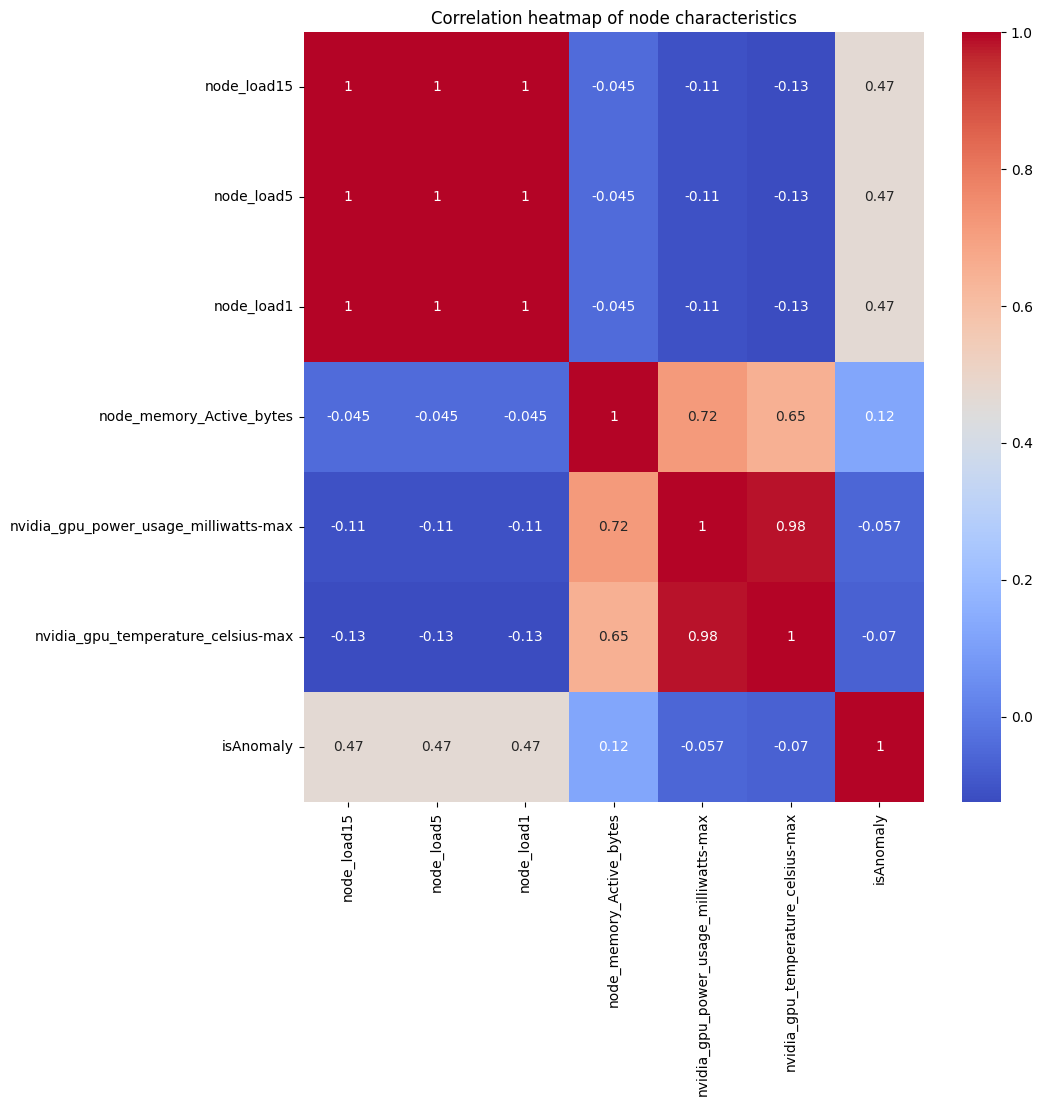

In [16]:

corr_matrix = prom_df.groupby('node').mean().corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap of node characteristics")
plt.show()

In [14]:
prom_df

,timestamp,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly,has_GPU
0,2022-08-01 23:00:30,r12n20,3.25,2.43,4.40,4585050000.00,0.00,0.00,0,False
1,2022-08-01 23:01:00,r12n20,3.21,2.41,3.49,4195340000.00,0.00,0.00,0,False
2,2022-08-01 23:01:30,r12n20,3.14,2.27,2.51,4248640000.00,0.00,0.00,0,False
3,2022-08-01 23:02:00,r12n20,3.07,2.15,1.91,4248610000.00,0.00,0.00,0,False
4,2022-08-01 23:02:30,r12n20,3.01,2.05,1.63,4266120000.00,0.00,0.00,0,False
...,...,...,...,...,...,...,...,...,...,...
123565292,2022-09-30 11:20:00,r35n5,6.33,2.92,1.16,16122600000.00,156186.00,57.00,0,True
123565293,2022-09-30 11:20:30,r35n5,6.16,2.73,1.10,16102000000.00,160405.00,55.00,0,True
123565294,2022-09-30 11:21:00,r35n5,5.99,2.55,0.99,16122500000.00,165284.00,58.00,0,True
123565295,2022-09-30 11:21:30,r35n5,5.83,2.40,1.00,16123300000.00,164491.00,60.00,0,True


/tmp/ipykernel_2115954/3609545016.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


                                       node_load15  node_load5  node_load1  \
node_load15                                   1.00        1.00        0.99   
node_load5                                    1.00        1.00        1.00   
node_load1                                    0.99        1.00        1.00   
node_memory_Active_bytes                      0.10        0.10        0.10   
nvidia_gpu_power_usage_milliwatts-max        -0.02       -0.02       -0.02   
nvidia_gpu_temperature_celsius-max           -0.02       -0.02       -0.02   
isAnomaly                                     0.43        0.43        0.43   

                                       node_memory_Active_bytes  \
node_load15                                                0.10   
node_load5                                                 0.10   
node_load1                                                 0.10   
node_memory_Active_bytes                                   1.00   
nvidia_gpu_power_usage_milliwatts-max   

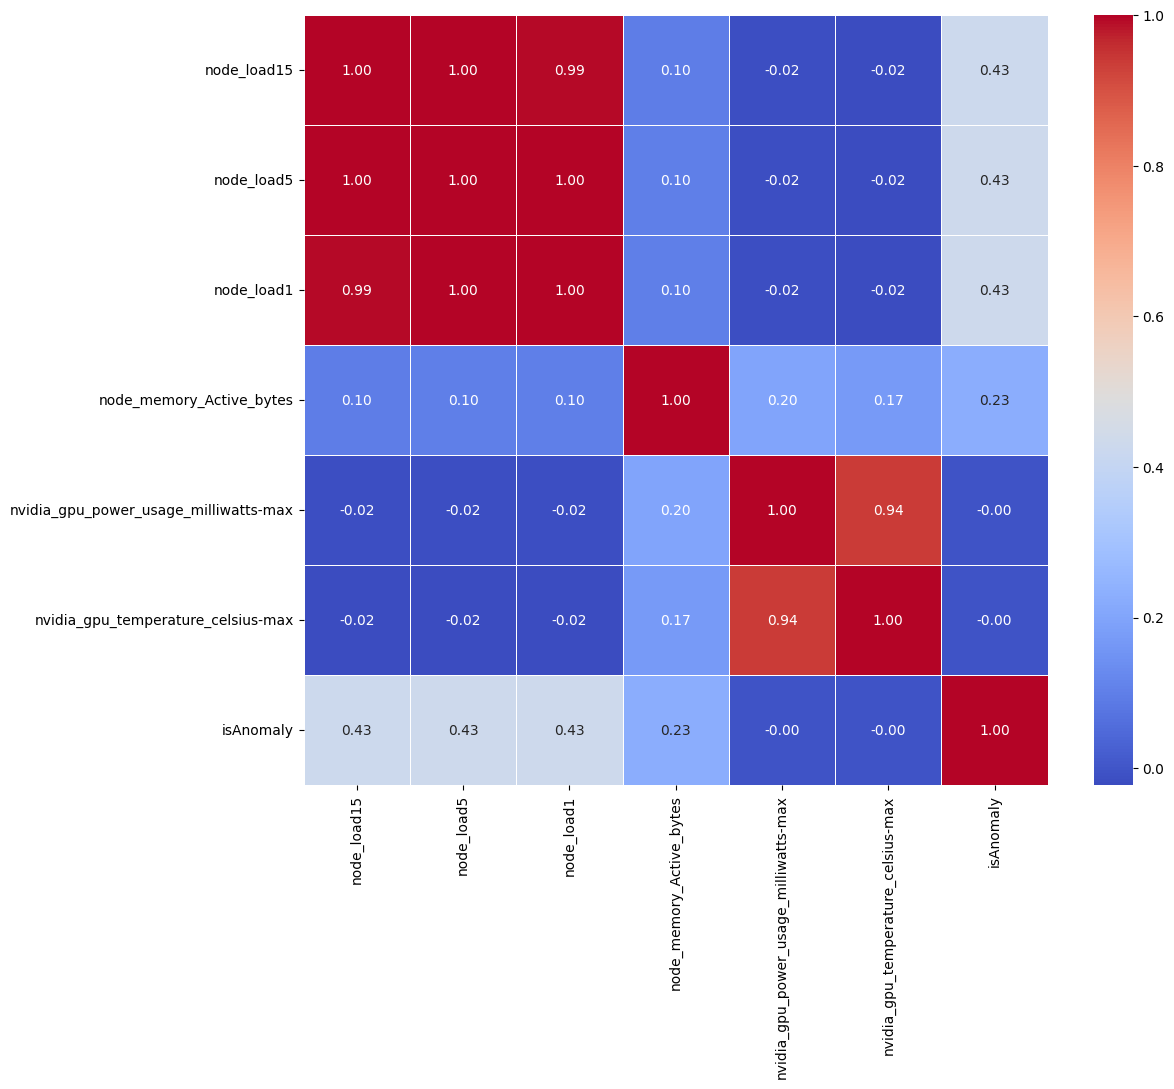

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = prom_df.drop(columns=['has_GPU'])

correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)


plt.savefig("corr.pdf", bbox_inches='tight')
plt.show()


In [17]:
plt.savefig("corr.pdf", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data_to_cluster = prom_df.drop(columns=['node', 'timestamp'])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=4, random_state=0).fit(data_scaled)

prom_df['cluster'] = kmeans.labels_

print(prom_df['cluster'].value_counts())

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

cluster_centers_df = pd.DataFrame(cluster_centers, columns=data_to_cluster.columns)

for i, row in cluster_centers_df.iterrows():
    print(f"Cluster {i} center has the following key characteristics:")
    for column in row.index:
        print(f"{column}: {row[column]:.2f}")


/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    99760620
3    20123643
1     3620511
2       60523
Name: cluster, dtype: int64
Cluster 0 center has the following key characteristics:
node_load15: 6.64
node_load5: 6.61
node_load1: 6.60
node_memory_Active_bytes: 4934734500.34
nvidia_gpu_power_usage_milliwatts-max: 1264.18
nvidia_gpu_temperature_celsius-max: 1.31
isAnomaly: -0.00
cluster: -0.00
Cluster 1 center has the following key characteristics:
node_load15: 7.99
node_load5: 8.02
node_load1: 8.03
node_memory_Active_bytes: 31590426580.30
nvidia_gpu_power_usage_milliwatts-max: 236362.97
nvidia_gpu_temperature_celsius-max: 78.95
isAnomaly: 0.03
cluster: 3.00
Cluster 2 center has the following key characteristics:
node_load15: 1946.39
node_load5: 1950.55
node_load1: 1951.67
node_memory_Active_bytes: 2234216843.18
nvidia_gpu_power_usage_milliwatts-max: 0.00
nvidia_gpu_temperature_celsius-max: 0.00
isAnomaly: 1.00
cluster: 1.00
Cluster 3 center has the following key characteristics:
node_load15: 27.42
node_load5: 27.69
node_load1: 2

In [22]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

cluster_centers_df = pd.DataFrame(cluster_centers, columns=prom_df.columns.drop(['node', 'timestamp', 'cluster']))

cluster_centers_df

ValueError: Shape of passed values is (4, 8), indices imply (4, 7)

In [24]:
cluster_describe = prom_df.groupby('cluster').describe()
cluster_describe


node_load15                                                        \
              count    mean    std    min     25%     50%     75%     max   
cluster                                                                     
0       99760620.00    6.64   7.15   0.00    0.01    1.82   15.62   93.26   
1          60520.00 1946.43 670.05 234.83 1363.87 1816.93 2529.13 4905.28   
2       20140702.00   27.45  49.60   0.00    7.08   15.07   16.11 1937.17   
3        3603455.00    7.77  10.63   0.00    3.41    4.63    7.33  151.69   

         node_load5          ... nvidia_gpu_temperature_celsius-max        \
              count    mean  ...                                75%   max   
cluster                      ...                                            
0       99760620.00    6.61  ...                               0.00 77.00   
1          60520.00 1950.60  ...                               0.00  0.00   
2       20140702.00   27.71  ...                               0.00 78.00   
3        3603455.00    7.79  ...                              86.00 93.00   

          isAnomaly                                     
              count mean  std  min  25%  50%  75%  max  
cluster                                                 
0       99760620.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1          60520.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00  
2       20140702.00 0.17 0.37 0.00 0.00 0.00 0.00 1.00  
3        3603455.00 0.03 0.17 0.00 0.00 0.00 0.00 1.00  

[4 rows x 56 columns]

In [25]:
overall_describe = prom_df.describe()
print(overall_describe)

       node_load15   node_load5   node_load1  node_memory_Active_bytes  \
count 123565297.00 123565297.00 123565297.00              123565297.00   
mean         11.01        11.03        11.04            11252140795.71   
std          50.60        50.83        50.96            16806257004.12   
min           0.00         0.00         0.00                      0.00   
25%           0.05         0.06         0.07             1588990000.00   
50%           4.74         4.28         4.09             3867960000.00   
75%          16.00        16.02        16.00            14265000000.00   
max        4905.28      4908.67      4910.27          2100090000000.00   

       nvidia_gpu_power_usage_milliwatts-max  \
count                           123565297.00   
mean                                 8060.19   
std                                 41733.91   
min                                     0.00   
25%                                     0.00   
50%                                     0.00 

In [29]:
node_stats = prom_df.groupby('node').agg(['max', 'min', 'mean', 'std'])

for column in node_stats.columns.levels[0]:
    max_node = node_stats[(column, 'max')].idxmax()
    min_node = node_stats[(column, 'min')].idxmin()
    print(f"For {column}: Node {max_node} has the highest maximum value of {node_stats.loc[max_node, (column, 'max')]:.2f}, "
          f"Node {min_node} has the lowest minimum value of {node_stats.loc[min_node, (column, 'min')]:.2f}.")


For node_load15: Node r11n29 has the highest maximum value of 4905.28, Node r10n1 has the lowest minimum value of 0.00.
For node_load5: Node r11n29 has the highest maximum value of 4908.67, Node r10n1 has the lowest minimum value of 0.00.
For node_load1: Node r11n29 has the highest maximum value of 4910.27, Node r10n1 has the lowest minimum value of 0.00.
For node_memory_Active_bytes: Node r23n23 has the highest maximum value of 2100090000000.00, Node r11n16 has the lowest minimum value of 0.00.
For nvidia_gpu_power_usage_milliwatts-max: Node r28n4 has the highest maximum value of 422388.00, Node r10n1 has the lowest minimum value of 0.00.
For nvidia_gpu_temperature_celsius-max: Node r34n2 has the highest maximum value of 93.00, Node r10n1 has the lowest minimum value of 0.00.
For isAnomaly: Node r10n1 has the highest maximum value of 1.00, Node r10n1 has the lowest minimum value of 0.00.
For cluster: Node r28n2 has the highest maximum value of 3.00, Node r10n1 has the lowest minimum v

/tmp/ipykernel_2082131/1347928325.py:2: FutureWarning: ['timestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  node_stats = prom_df.groupby('node').agg(['max', 'min', 'mean', 'std'])


In [32]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

cluster_centers_df = pd.DataFrame(cluster_centers, columns=data_scaled.columns)

for i, row in cluster_centers_df.iterrows():
    print(f"Cluster {i} center has the following key characteristics:")
    for column in row.index:
        print(f"{column}: {row[column]:.2f}")


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

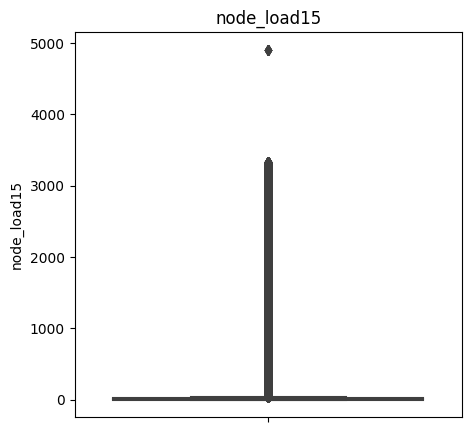

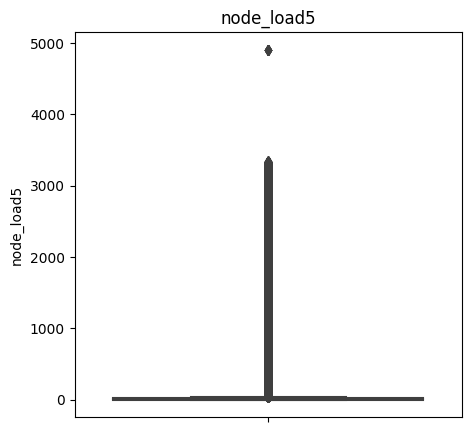

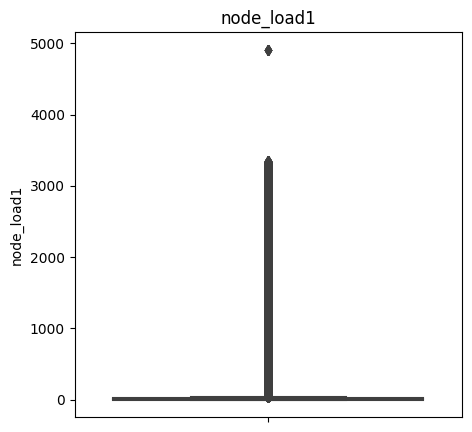

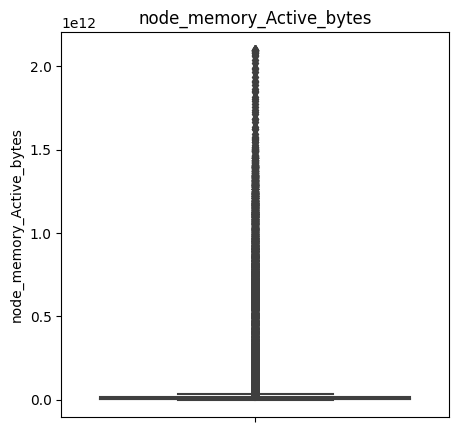

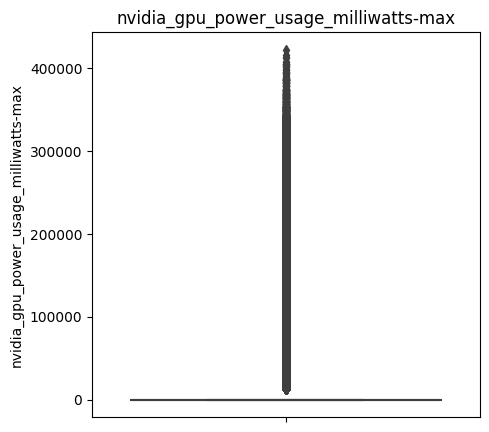

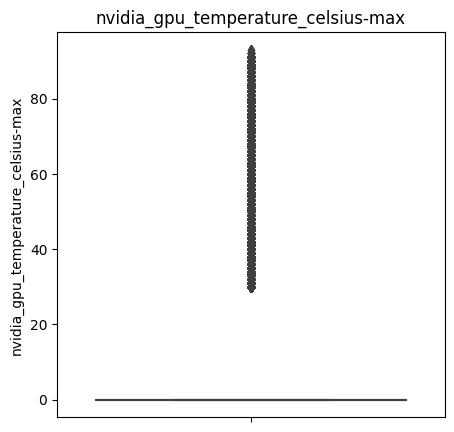

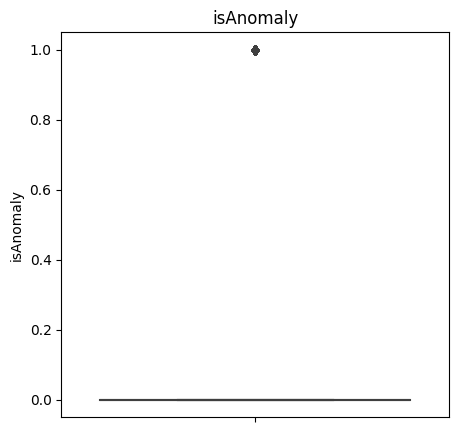

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in prom_df.columns:
    if prom_df[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(5, 5))
        sns.boxplot(y=prom_df[column])
        plt.title(column)
        plt.show()


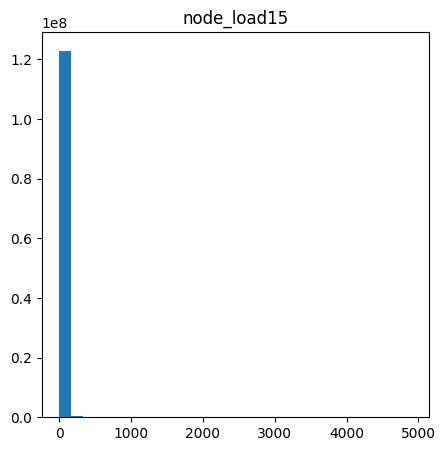

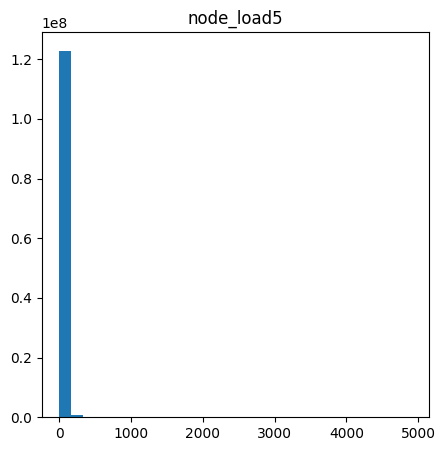

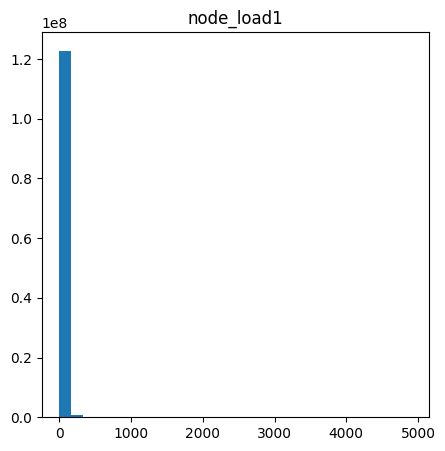

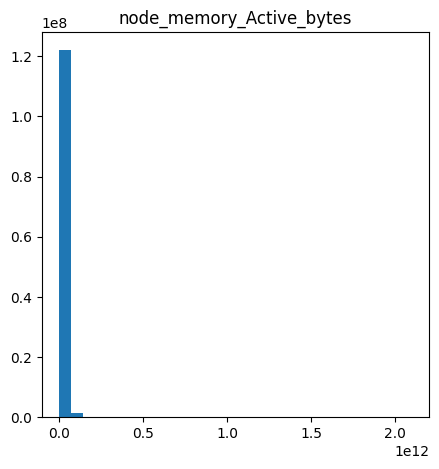

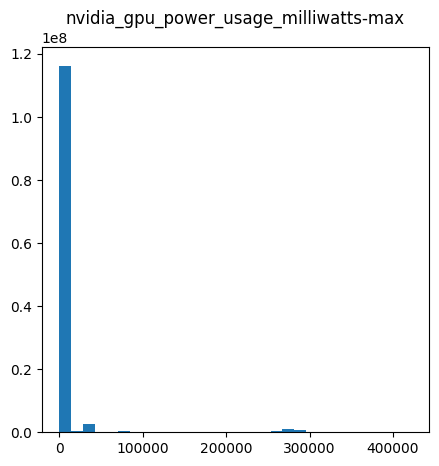

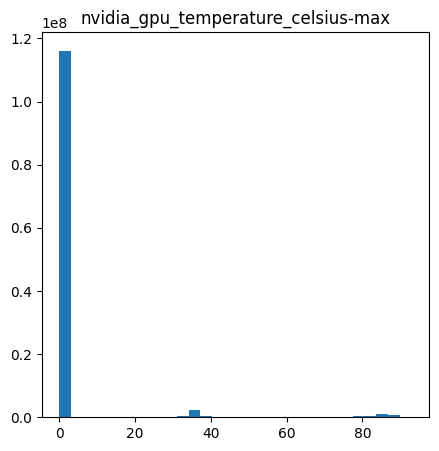

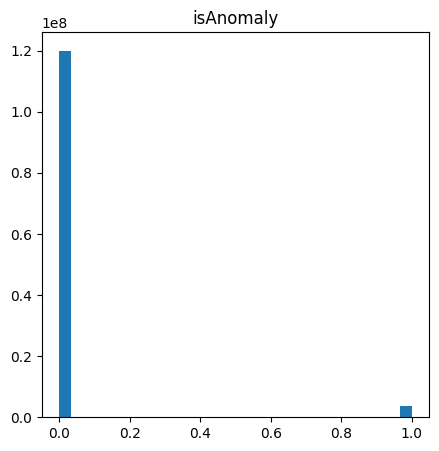

In [14]:
for column in prom_df.columns:
    if prom_df[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(5, 5))
        plt.hist(prom_df[column], bins=30)
        plt.title(column)
        plt.show()